In [9]:

# Cell 1: Import necessary libraries
import matplotlib.pyplot as plt  # For creating visual plots and graphs.
import numpy as np  # For numerical operations and matrix manipulations.
import cv2  # For image processing operations.
from tqdm import trange  # For displaying progress bars during loops.
from gymnasium.utils.env_checker import check_env  # For verifying gym environment setups.
from flygym import Fly, Camera  # For simulating a fly agent and attaching a camera.
from flygym.arena import FlatTerrain, OdorArena  # For setting up simulation arenas.
from flygym.examples.turning_controller import HybridTurningNMF  # For using a specific fly movement controller.
from pathlib import Path  # For filesystem path operations.

# Cell 2: Define parameters and ensure output directory existence
Path("./outputs/outputs_finaux").mkdir(exist_ok=True)  # Create directory if it doesn't exist.

# Cell 4: Create the arena
peak_odor_intensity = np.array([[1, 0], [0, 0], [0, 0]])  # Define peak intensities at odor sources.
odor_source_A = np.array([[-2, 1, 0.2], [-5, -5, 0.2], [-1, 5, 0.2]])  # Coordinates for mobile odor sources.

marker_colors = [[255, 127, 14]]  # Base color (orange) in RGB.
marker_colors_A = marker_colors + [[0, 0, 128], [0, 0, 128]]  # Additional colors (blue) for markers.
marker_colors = np.array([[*np.array(color) / 255, 1] for color in marker_colors])  # Normalize RGB to RGBA.
marker_colors_A = np.array([[*np.array(color) / 255, 1] for color in marker_colors_A])  # Convert to RGBA for visualization.

flat_terrain_arena = FlatTerrain()  # Initialize a flat terrain for the arena.
arena = OdorArena(
    odor_source=odor_source_A,
    peak_odor_intensity=peak_odor_intensity,
    diffuse_func=lambda x: x**-2,  # Diffusion function for odor spread.
    marker_colors=marker_colors_A,
    marker_size=0.3  # Size of markers within the simulation.
)

# Cell 5: Setup the fly and camera
contact_sensor_placements = [
    f"{leg}{segment}" for leg in ["LF", "LM", "LH", "RF", "RM", "RH"] for segment in ["Tibia", "Tarsus1", "Tarsus2", "Tarsus3", "Tarsus4", "Tarsus5"]
]  # Define placement of contact sensors on the fly's body.

# Set up the fly facing horizontally to the right
fly = Fly(
    spawn_pos=(1, 1, 0.2),
    spawn_orientation=(0, 0, -np.pi/2),  # Orientation set to face right.
    contact_sensor_placements=contact_sensor_placements,
    enable_olfaction=True,  # Enable the fly's olfaction sensors.
    enable_adhesion=True,  # Enable the fly's ability to adhere to surfaces.
    draw_adhesion=False  # Do not visualize adhesion effects.
)

cam = Camera(
    fly=fly,
    camera_id="birdeye_cam",
    play_speed=0.2,  # Simulation playback speed.
    window_size=(1000, 608)  # Dimensions of the camera output window.
)

sim = HybridTurningNMF(
    fly=fly,
    cameras=[cam],
    arena=arena
)

# Simulation parameters
global white_area_bounds, attractive_gain, aversive_gain, decision_interval, run_time, num_decision_steps, physics_steps_per_decision_step, speed, curr_time, initial_xpos, n_delays
odor_dimensions = len(peak_odor_intensity[0])  # Number of dimensions in the odor intensity array.
white_area_bounds = [odor_source_A[1][:2], odor_source_A[2][:2]]  # Initial bounds for white areas.
attractive_gain = -500  # Negative gain for attraction behaviors.
aversive_gain = 500  # Positive gain for aversion behaviors.
decision_interval = 0.05  # Time interval between decision steps in seconds.
run_time = 10  # Total run time of the simulation in seconds.
num_decision_steps = int(run_time / decision_interval)  # Total number of decision-making steps.
physics_steps_per_decision_step = int(decision_interval / sim.timestep)  # Number of physics updates per decision step.
speed = 5  # Movement speed factor.
curr_time = 0  # Initial time counter.
initial_xpos = odor_source_A[0][0]  # Initial x-coordinate position.
n_delays = 10  # Number of time steps for delays.

# Cell 3: Define utility functions
def draw_white_area_corners(frame, bounds, color=(0, 0, 255), size=5):
    """Draw corners of a designated area on an image frame to visualize boundaries.
    
    Parameters:
    frame (ndarray): Image frame on which to draw the corners.
    bounds (list): List containing two coordinate tuples defining the area.
    color (tuple): Color of the corners (in BGR format).
    size (int): Size of the corner marks.
    """
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    corners = [(x1, y1), (x1, y2), (x2, y1), (x2, y2)]
    for corner in corners:
        pixel_x = int((corner[0] + 6.75) * 100)  # Scale position to pixel coordinates.
        pixel_y = int((corner[1] - 0.46) * 100)
        cv2.circle(frame, (pixel_x, pixel_y), size, color, -1)
    return frame

def is_in_white_area(position, bounds):
    """Determine if a position is within specified bounds.
    
    Parameters:
    position (tuple): x and y coordinates to check.
    bounds (list): List containing two coordinate tuples defining the area.
    """
    x, y = position[:2]
    x1, y1 = bounds[0]
    x2, y2 = bounds[1]
    return x1 <= x <= x2 and y1 <= y <= y2

# Initialize and bind markers to the odor sources
marker = arena.root_element.find("body", "odor_source_marker_0")
sim.physics.bind(marker).mocap_pos[:2] = odor_source_A[0][:2]
arena.odor_source[0, :2] = odor_source_A[0][:2]

markerA = arena.root_element.find("body", "odor_source_marker_1")
sim.physics.bind(marker).mocap_pos[:2] = odor_source_A[1][:2]
arena.odor_source[0, :2] = odor_source_A[1][:2]

markerB = arena.root_element.find("body", "odor_source_marker_2")
sim.physics.bind(markerB).mocap_pos[:2] = odor_source_A[2][:2]
arena.odor_source[1, :2] = odor_source_A[2][:2]

# Cell 7: Run the simulation
run_simulation(fly_mobile=False, source_mobile=False, bounds=True)

  0%|          | 0/200 [00:00<?, ?it/s]

100%|██████████| 200/200 [15:29<00:00,  4.65s/it]


In [10]:
x = list(range(num_decision_steps))
#divide x by 100
x = [((i+1)*48) / 200 for i in x]

In [11]:
cam.save_video("./outputs/outputs_finaux/exp_C_2_4.mp4")
#show graph HRC_model through time

[swscaler @ 0x7fa19f14a000] Warning: data is not aligned! This can lead to a speed loss


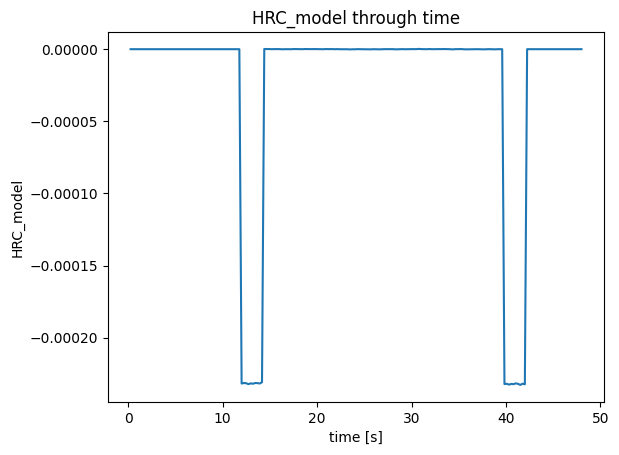

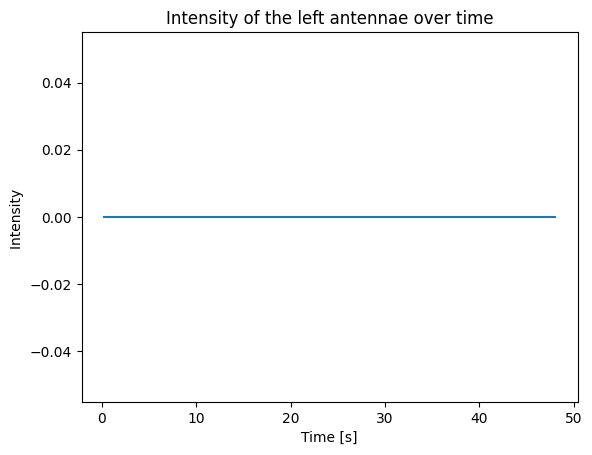

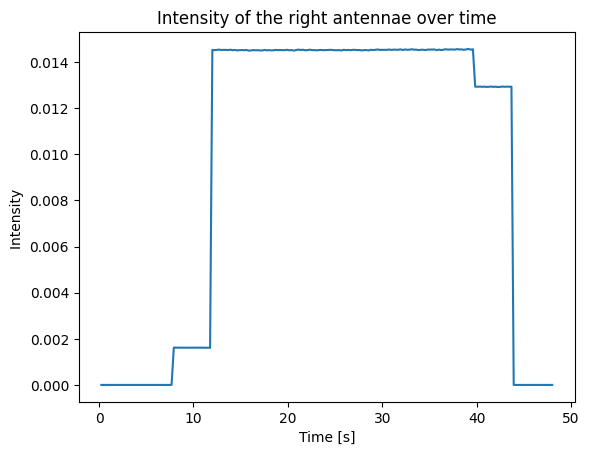

In [12]:

plt.plot(x,HRC_model)
 #change the values of the xlabel

plt.xlabel('time [s]')
plt.ylabel('HRC_model')
plt.title('HRC_model through time')
plt.savefig("./outputs/HRC_exp_C_2_4.png")
plt.show()

#HRC_model

# Extract the first column from odor_history
first_column = [entry[0] for entry in odor_history]

# Plot the first column
plt.plot(x,first_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the left antennae over time')
plt.savefig("./outputs/antenne_1_exp_C_2_4.png")
plt.show()

# Extract the second column from odor_history
second_column = [entry[1] for entry in odor_history]

# Plot the second column
plt.plot(x,second_column)
plt.xlabel('Time [s]')
plt.ylabel('Intensity ')
plt.title('Intensity of the right antennae over time')
plt.savefig("./outputs/antenne_2_exp_C_2_4.png")
plt.show()